In [7]:
from qpe_jax import *

import numpy
from numpy.random import uniform

from scipy.stats import unitary_group
from scipy.optimize import minimize

from functools import reduce
from itertools import product
from time import time

import pickle

import matplotlib.pyplot as plt

## Cost function

In [2]:
@jax.jit
def fun_dm(x):
    x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
    U = ansatz_func(x_ans, *ansatz_args)
    H = jnp.zeros(d, dtype=complex)
    for q in range(len(x_est)):
        H += x_est[q]*projs[q]
    # H_u = (U.conj().T*H)@U
    H_u = U.conj().T@jnp.diag(H)@U
    H_u_sq = H_u@H_u
    # expecs = jnp.trace(H_u@dms_train_c, axis1=1, axis2=2).real
    # disps = jnp.trace(H_u_sq@dms_train_c, axis1=1, axis2=2).real - expecs**2
    expecs = []
    disps = []
    for j in range(len(labels_train)):
        expecs.append(jnp.trace(dms_train_c[j]@H_u).real)
        disps.append(jnp.trace(dms_train_c[j]@H_u_sq).real)
    expecs = jnp.array(expecs)
    disps = jnp.array(disps) - expecs**2
    f = w_ls*jnp.sum((expecs - labels_train)**2)
    f += w_var*jnp.sum(disps)
    return f

# Work --- many runs

## Dataset preparation

/home/investigator/Work/qcnn-var/qpe_jax.py:29: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  res = sqrtm(res)


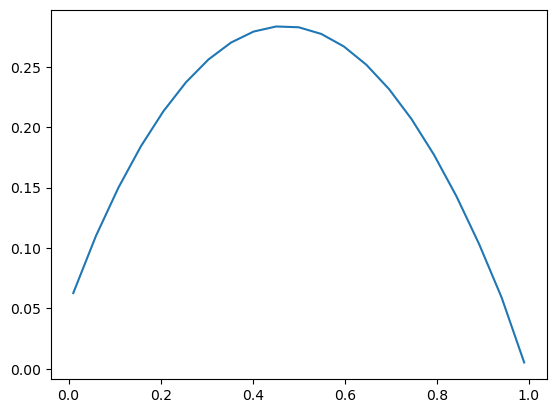

In [3]:
n_inp = 5
p = 1/4
eps = 0.01
dp = 0.01
a = 0
b = 1
T = 10
V = 21

d = 2**n_inp
# U = unitary_group.rvs(d); U_info = "random"
U = jnp.eye(d); U_info = "identity"

ghz_p = jnp.array([1] + [0]*(d - 2) + [1])/jnp.sqrt(2); ghz_p =jnp.outer(ghz_p, ghz_p.conj())
ghz_m = jnp.array([1] + [0]*(d - 2) + [-1])/jnp.sqrt(2); ghz_m =jnp.outer(ghz_m, ghz_m.conj())

labels_train = jnp.linspace(a + eps, b - eps, T)
dms_train = []
dms_der_train = []
for i in range(T):
    # dm = U@diag([p, 1 - p] + [0]*(d - 2))@U.conj().T
    dm = p*ghz_p + (1 - p)*ghz_m ; dm_info = "ghz_pm"
    dms_train.append(labels_train[i]*dm + (1 - labels_train[i])/d*jnp.eye(d))
    dms_der_train.append(dm - 1/d*jnp.eye(d))

labels_test = jnp.linspace(a + eps, b - eps, V)
dms_test = []
dms_der_test = []
QFIs_test = []
for i in range(V):
    # dm = U@diag([r, 1 - r] + [0]*(d - 2))@U.conj().T
    dm = p*ghz_p + (1 - p)*ghz_m ; dm_info = "ghz_pm"
    dms_test.append(labels_test[i]*dm + (1 - labels_test[i])/d*jnp.eye(d))
    dm_m = (labels_test[i] - dp)*dm + (1 - (labels_test[i] - dp))/d*jnp.eye(d)
    dm_p = (labels_test[i] + dp)*dm + (1 - (labels_test[i] + dp))/d*jnp.eye(d)
    QFIs_test.append(2*(1 - jnp.sqrt(fidelity(dm_m, dm_p))) / dp**2 + 1e-10) # via centered differences
    dms_der_test.append(dm - 1/d*jnp.eye(d))

plt.plot(labels_test, 1/jnp.array(QFIs_test))

## Measurements, copies, other parameters

In [4]:
n_copies = 1
n_tot = 2**int(jnp.ceil(jnp.log2(n_inp*n_copies)))
n_ext = n_tot - n_inp*n_copies

ansatz_func = hea_rzz
ansatz_name = "hea_rzz"
n_layers = 5
ansatz_info = "-l=%d" % n_layers
n_pars_ans = 3*n_layers*n_tot
ansatz_args = [n_tot, n_layers]

n_meas_list = [0]

d = 2**n_tot 
n_pars_est = 2**len(n_meas_list) # number of eigenvalues x_i

w_ls = 1e0
w_var = 1e-4

In [8]:
basis = product([jnp.array([1, 0]), jnp.array([0, 1])], repeat=len(n_meas_list))
projs = []
for line in basis:
    proj = [jnp.ones(2)]*n_tot
    for q in range(len(n_meas_list)):
        proj[n_meas_list[q]] = line[q]
    proj = reduce(jnp.kron, proj)
    projs.append(proj)
projs = jnp.array(projs)

dms_train_c = jnp.array([reduce(jnp.kron, [dm]*n_copies + [numpy.diag([1, 0])]*(n_tot - n_inp)) for dm in dms_train])

## Optimization

In [9]:
def callback(x):
    niter[0] += 1
    print("\t\t\tIteration: %d | Time passed: %d s" %(niter[0], time() - time_start), end="\r")
    return None

method = "BFGS"

In [ ]:
n_runs = 10

pars_list = []
times_list = []
for r in range(n_runs):
    print("r:", r)

    time_start = time()
    niter = [0]
    # x0 = jnp.concatenate([normal(0, 0.1, n_pars_ans), normal(0, 0.1, n_pars_est)])
    x0 = jnp.concatenate([uniform(0, 2*jnp.pi, n_pars_ans), uniform(-1, 1, n_pars_est)])
    
    result = minimize(fun_dm, x0, method=method, callback=callback)
    pars = result.x

    time_finish = time() - time_start

    print("\n\t Finished in %.2f s" % time_finish)
    print("\t Cost: %f" % result.fun)
    
    pars_list.append(pars)
    times_list.append(time_finish)

r: 0
			Iteration: 158 | Time passed: 1383 s

In [ ]:
# n_runs = 10

# lr = 0.01
# n_iter = 30000
# gtol = 1e-5

# fvals_list = []
# pars_list = []
# times_list = []
# for r in range(n_runs):
#     print("r:", r)
#     time_start = time()
    
#     x0 = jnp.array(uniform(-1, 1, n_pars_ans + n_pars_est))
    
#     pars = jnp.array(x0)

#     solver = optax.adamw(learning_rate=lr)
#     opt_state = solver.init(pars)
#     fval_min = 1e10 # just a large number
#     fvals = []

#     for i in range(n_iter):
#         fval, grad = jax.value_and_grad(fun)(pars)
#         updates, opt_state = solver.update(grad, opt_state, pars)
#         pars = optax.apply_updates(pars, updates)
#         gnorm = jnp.linalg.norm(grad)
#         fvals.append(fval)
#         print(f"\t Step: {i} | Loss: {fval} | gnorm: {gnorm}", end="\r")
#         if fval < fval_min:
#             fval_min = fval
#             pars_min = pars
#         if gnorm < gtol:
#             break
    
#     time_finish = time() - time_start

#     print("\n\t Finished in %.2f s" % time_finish)
    
#     fvals_list.append(fvals)
#     pars_list.append(pars_min)
#     times_list.append(time_finish)

## Infer and plot

In [ ]:
dms_test_c = jnp.array([reduce(jnp.kron, [dm]*n_copies + [numpy.diag([1, 0])]*(n_tot - n_inp)) for dm in dms_test])
dms_der_test_c = jnp.array([reduce(jnp.kron, [dm]*n_copies + [numpy.diag([1, 0])]*(n_tot - n_inp)) for dm in dms_der_test])

In [ ]:
dp = 1e-5
expecs_list = []
expecs_der_list = []
disps_list = []
CFIs_list = []
biass_list = []
for r in range(n_runs):
    pars = jnp.array(pars_list[r])
    pars_ans, pars_est = pars[:n_pars_ans], pars[n_pars_ans:]
    U = ansatz_func(pars_ans, *ansatz_args) 
    projs_u = jnp.array([U.conj().T@jnp.diag(proj)@U for proj in projs])
    expecs_test = []
    expecs_der_test = []
    disps_test = []
    CFIs_test = []
    for j in range(V):
        print(f"r: {r} | j: {j}", end="\r")
        probs = [jnp.trace(dms_test_c[j]@proj).real for proj in projs_u]
        probs_der = [jnp.trace(dms_der_test_c[j]@proj_u).real for proj_u in projs_u]
        expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
        expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
        disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        expecs_test.append(expec)
        expecs_der_test.append(expec_der)
        disps_test.append(disp)
        CFIs_test.append(CFI)
    biass_test = jnp.array(expecs_test) - labels_test
    expecs_list.append(expecs_test)
    expecs_der_list.append(expecs_der_test)
    disps_list.append(disps_test)
    CFIs_list.append(CFIs_test)
    biass_list.append(biass_test)

In [ ]:
expecs_mean = numpy.mean(numpy.array(expecs_list), axis=0)
# expecs_der_mean = jnp.mean(jnp.array(expecs_der_list), axis=0)
disps_mean = numpy.mean(numpy.array(disps_list), axis=0)
disps_red_mean = numpy.mean(numpy.array(disps_list)/numpy.array(expecs_der_list)**2, axis=0)
disps_red_std = numpy.std(numpy.array(disps_list)/numpy.array(expecs_der_list)**2, axis=0)
CFIs_mean = numpy.mean(numpy.array(CFIs_list), axis=0)
biass_sq_mean = numpy.mean((numpy.array(expecs_list) - labels_test)**2, axis=0)
biass_sq_std = numpy.std((numpy.array(expecs_list) - labels_test)**2, axis=0)

In [ ]:
biass_sq_fill_l = numpy.array(biass_sq_mean - biass_sq_std)
biass_sq_fill_l = numpy.array([biass_sq_fill_l[i] if biass_sq_fill_l[i] > 0 else 0 for i in range(V)])
biass_sq_fill_u = numpy.array(biass_sq_mean + biass_sq_std)
disps_red_fill_l = numpy.array(disps_red_mean - disps_red_std)
disps_red_fill_l = numpy.array([disps_red_fill_l[i] if disps_red_fill_l[i] > 1/QFIs_test[i] else 1/QFIs_test[i] for i in range(V)])
disps_red_fill_u = numpy.array(disps_red_mean + disps_red_std)

In [ ]:
print(f"n_inp: {n_inp} | n_tot: {n_tot}")
print(f"n_meas_list: {n_meas_list}")
print(f"{ansatz_name} | {ansatz_info}")
print("Average MSE:                   ", sum(biass_sq_mean)/V)
print("Average total variance:        ", sum(disps_mean)/V)
print("Average total variance reduced:", sum(disps_red_mean)/V)

plt.figure(figsize=(6, 4))
# plt.scatter(labels_train, biass_train**2, s=100)
plt.plot(labels_test, expecs_mean)
plt.plot(labels_test, labels_test)
# plt.fill_between(labels_test, biass_sq_fill_l, biass_sq_fill_u, alpha=0.35, color="tab:blue")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\mathsf{a}$")
# plt.legend()
plt.grid()
# plt.savefig(save_path + file_info + postfix + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6, 4))
# plt.scatter(labels_train, biass_train**2, s=100)
plt.plot(labels_test, biass_sq_mean)
plt.fill_between(labels_test, biass_sq_fill_l, biass_sq_fill_u, alpha=0.35, color="tab:blue")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$(\mathsf{a} - \alpha)^2$")
# plt.legend()
plt.grid()
# plt.savefig(save_path + file_info + postfix + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6, 4))
# plt.scatter(labels_train, disps_train/expecs_der_train**2, s=150, zorder=10)
plt.plot(labels_test, disps_red_mean, zorder=10)
plt.fill_between(labels_test, disps_red_fill_l, disps_red_fill_u, alpha=0.35, color="tab:blue")
plt.plot(numpy.sort(labels_test), 1/jnp.array(QFIs_test), color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(numpy.sort(labels_test), 1/CFIs_mean, label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed", zorder=12) # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$" )
plt.xlabel(r"$\alpha$")
plt.grid()
# plt.yscale("log")
plt.legend()
# plt.savefig(save_path + file_info + postfix + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

n_inp: 5 | n_tot: 8
n_meas_list: [0]
hea_rzz | -l=5
Average MSE:                    3.927072123299168e-08
Average total variance:         0.6611243658866459
Average total variance reduced: 0.6620083604868168


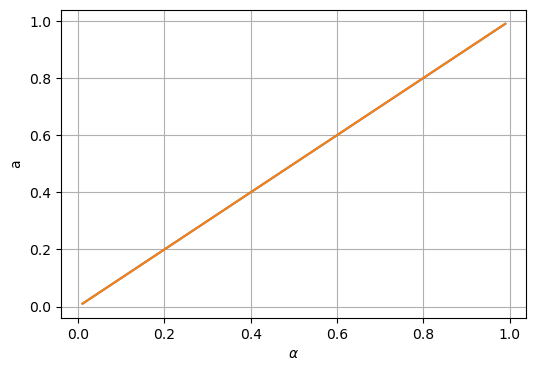

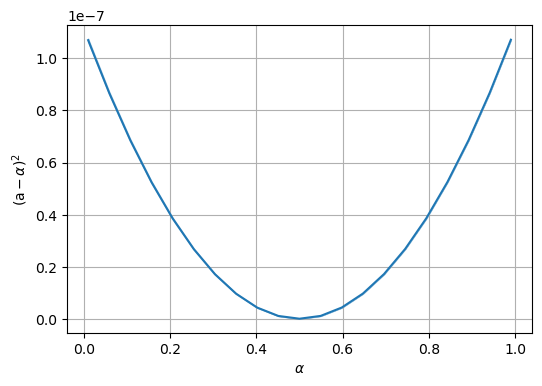

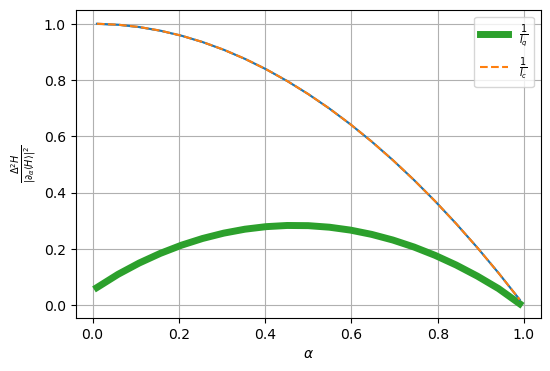

In [ ]:
path = f"/home/investigator/Work/qcnn-var/Results/linear_combination/"
info = f"{dm_info}-{ansatz_name}{ansatz_info}-U={U_info}-" + ("n=%d-c=%d-m=%s-r=%d-w_ls=%.1f-w_var=%.4f-p=%.2f" %(n_inp, n_copies, n_meas_list, n_runs, w_ls, w_var, p)).replace(" ", "")
path + info

In [ ]:
# check carefuly 

data_dict = {
    "n": n_inp,
    "c": n_copies,
    "a": a,
    "b": b,
    "w_ls": w_ls, 
    "w_var": w_var, 
    "dm_info": dm_info,
    "U_info": U_info,
    "p": p,
    "ansatz_name": ansatz_name,
    "ansatz_info": ansatz_info[1:],
    "n_meas_list": n_meas_list,
    "note": "Method: %s." %method, 
    "labels_train": numpy.array(labels_train),
    "labels_test": numpy.array(labels_test),
    "n_runs": n_runs,
    "pars_list": numpy.array(pars_list),
    "expecs_list": numpy.array(expecs_list),
    "expecs_der_list": numpy.array(expecs_der_list),
    "CFIs_list": numpy.array(CFIs_list),
    "QFIs": numpy.array(QFIs_test),
    "disps_list": numpy.array(disps_list),
    "times_list": numpy.array(times_list),
} 

print(path + info + ".dict")

# with open(path + info + ".dict", 'wb') as fp:
#     pickle.dump(data_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)